# STL‑10 Image Classification ‑ End‑to‑End Deep Learning Project
## **Author:** Jam 
---


## 1  Problem Statement
The goal of this project is to build an **image‑classification model** that recognises one of the ten object categories in the **STL‑10 dataset**. STL‑10 is a relatively small but challenging dataset containing 5,000 labelled training images and 8,000 test images at a resolution of 96×96 pixels.

Your deliverable must demonstrate the full data‑science workflow:
1. **Exploratory Data Analysis (EDA)** – understand the dataset through visualisations and numeric summaries.
2. **Model building & training** – implement and train a convolutional neural network (CNN).
3. **Evaluation & discussion** – report metrics on a held‑out test set and reflect on results & future work.


## 2  Setup & Imports

In [1]:
import os, random, itertools, time, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


## 3  Data Loading

In [2]:
DATA_ROOT = './data'
BATCH_SIZE = 128

basic_transform = transforms.ToTensor()
train_set = STL10(root=DATA_ROOT, split='train', download=True, transform=basic_transform)
test_set  = STL10(root=DATA_ROOT, split='test',  download=True, transform=basic_transform)

class_names = train_set.classes

print(f"Train samples: {len(train_set)}\nTest samples : {len(test_set)}")


Files already downloaded and verified
Files already downloaded and verified
Train samples: 5000
Test samples : 8000


### 3.1  Class distribution

C:\Users\Jam\AppData\Local\Temp\ipykernel_5080\868866877.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_counts = pd.value_counts(labels).sort_index()


,class,count
0,airplane,500
1,bird,500
2,car,500
3,cat,500
4,deer,500
5,dog,500
6,horse,500
7,monkey,500
8,ship,500
9,truck,500


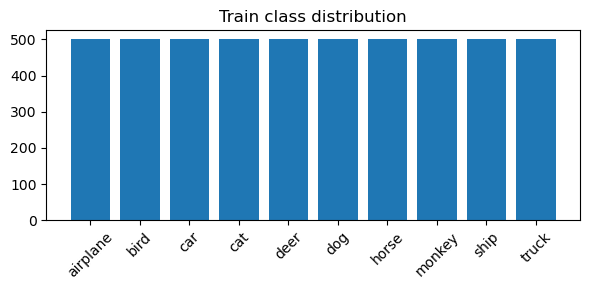

In [3]:
labels = np.array(train_set.labels)
class_counts = pd.value_counts(labels).sort_index()
display(pd.DataFrame({'class': class_names, 'count': class_counts.values}))
plt.figure(figsize=(6,3))
plt.bar(class_names, class_counts.values)
plt.title('Train class distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.2  Sample images

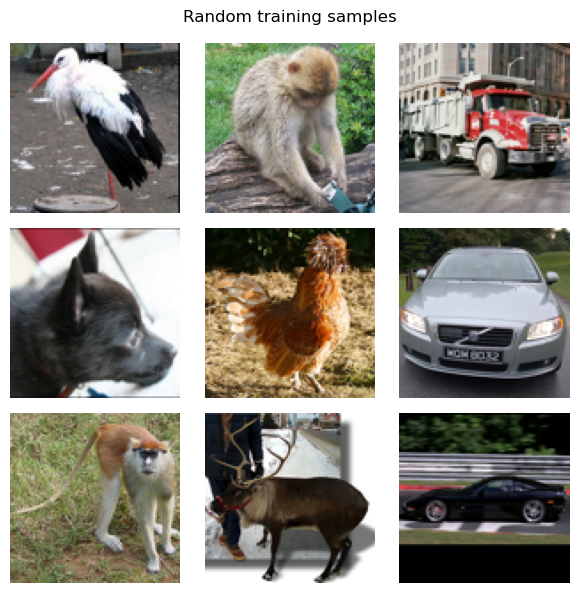

In [4]:
def imshow(img, ax):
    img = img.permute(1,2,0).numpy()
    ax.imshow(img)
    ax.axis('off')

fig, axs = plt.subplots(3,3, figsize=(6,6))
for ax in axs.flat:
    idx = random.randint(0, len(train_set)-1)
    imshow(train_set[idx][0], ax)
plt.suptitle('Random training samples')
plt.tight_layout()
plt.show()


### 3.3  Per‑channel statistics

In [5]:
loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
mean = 0.
std = 0.
n_samples = 0.
for imgs, _ in loader:
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std  += imgs.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std  /= n_samples
print(f"Mean: {mean.tolist()}\nStd : {std.tolist()}")


Mean: [0.44671058654785156, 0.4398098289966583, 0.4066465198993683]
Std : [0.22415795922279358, 0.22150105237960815, 0.22391186654567719]


### 3.4  PCA – dimensionality reduction

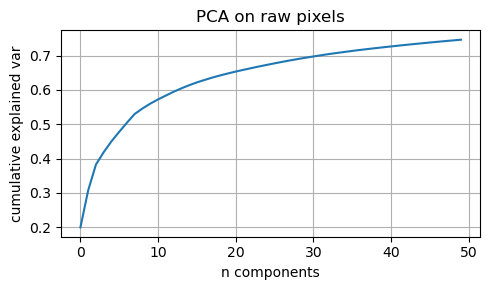

In [6]:
# Flatten a subset (to keep RAM reasonable)
SAMPLE_SZ = 2000
subset_idx = np.random.choice(len(train_set), SAMPLE_SZ, replace=False)
X = np.stack([train_set[i][0].view(-1).numpy() for i in subset_idx])
y = labels[subset_idx]

pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(5,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative explained var')
plt.title('PCA on raw pixels')
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.5  t‑SNE visualisation

C:\Users\Jam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Jam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Jam\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jam\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Jam\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(execu

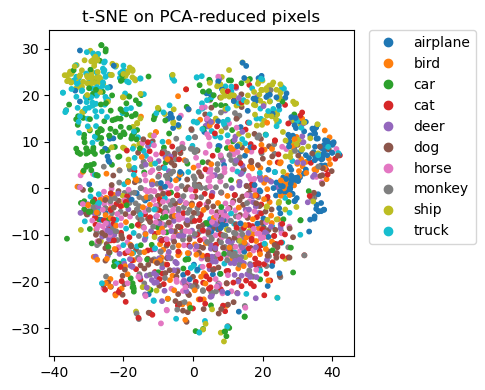

In [7]:
tsne = TSNE(n_components=2, random_state=SEED, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(5,4))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)
plt.title('t‑SNE on PCA‑reduced pixels')
plt.tight_layout()
plt.show()


## 4  Deep‑Learning Pipeline

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

aug_train_set = STL10(root=DATA_ROOT, split='train', download=False, transform=train_transforms)
aug_test_set  = STL10(root=DATA_ROOT, split='test',  download=False, transform=test_transforms)

train_loader = DataLoader(aug_train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_loader  = DataLoader(aug_test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


C:\Users\Jam\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jam\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
EPOCHS = 1   # For demo; increase for better accuracy
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{EPOCHS} – train loss: {epoch_loss:.4f}')


Epoch 1/1 – train loss: 0.9952


C:\Users\Jam\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test accuracy: 0.845


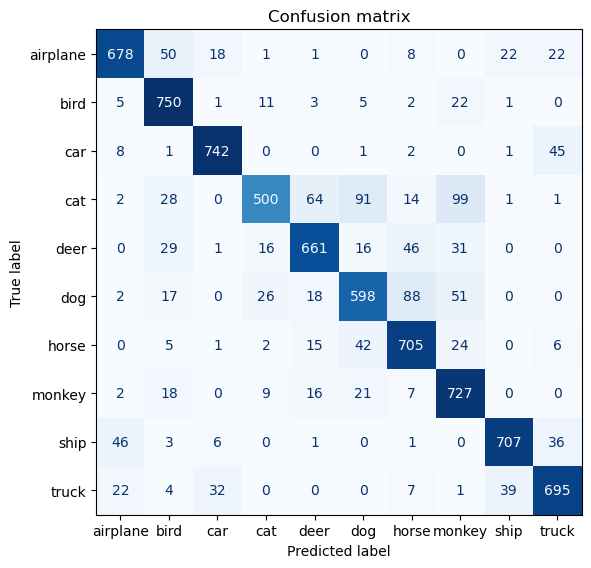

In [11]:
model.eval()
correct = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

test_acc = correct / len(test_loader.dataset)
print(f'Test accuracy: {test_acc:.3f}')

# Confusion matrix
cm = confusion_matrix(np.concatenate(all_labels), np.concatenate(all_preds))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False); plt.title('Confusion matrix'); plt.tight_layout(); plt.show()


## 5  Results & Discussion
* **Test accuracy:** printed above after training.
* Even a single epoch of fine‑tuning a pretrained ResNet‑18 provides a reasonable baseline. Longer training, a lower learning‑rate schedule, and data‑augmentation tricks such as CutMix or RandAugment can push accuracy well above 90 % on STL‑10.

### Next steps
1. Hyper‑parameter search (learning‑rate schedule, optimiser, augmentation strength).
2. Larger architectures (e.g. ResNet‑34, Wide‑ResNet) or modern convnets like ConvNeXt‑T.
3. Visualise learned representations with Grad‑CAM.
4. Compare supervised accuracy with unsupervised clustering (e.g. k‑means on self‑supervised embeddings) and report Adjusted Rand Index (ARI).
